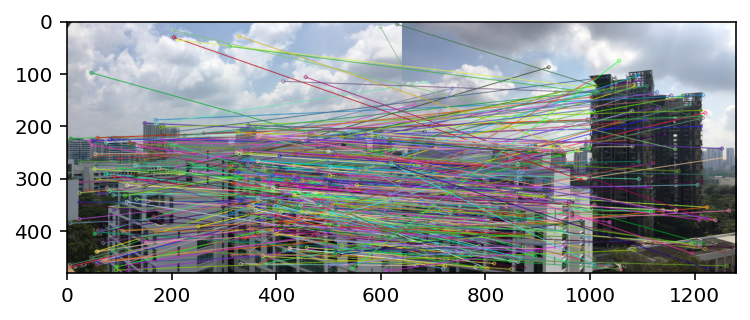

In [4]:
import cv2 as cv
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

image1 = cv.imread('./im01.jpg')
b,g,r = cv.split(image1)
img1 = cv.merge((r,g,b))
image2 = cv.imread('./im02.jpg')
b,g,r = cv.split(image2)
img2 = cv.merge((r,g,b))

sift = cv.SIFT_create()
kp_1, des_1 = sift.detectAndCompute(img1, None)
kp_2, des_2 = sift.detectAndCompute(img2, None)

M = len(des_1)
N = len(des_2)
matches1 = []
matches2 = []
for i in range(M):
    for j in range(N):
        if j == 0:
            best = sum((des_1[i]-des_2[j])**2)
            idx = 0
        else:
            tmp = sum((des_1[i]-des_2[j])**2)
            if tmp < best:
                idx = j
                best = tmp
    matches1.append(cv.DMatch(_distance=best,_queryIdx=i,_trainIdx=idx,_imgIdx=0))
                

for i in range(N):
    for j in range(M):
        if j == 0:
            best = sum((des_2[i]-des_1[j])**2)
            idx = 0
        else:
            tmp = sum((des_2[i]-des_1[j])**2)
            if tmp < best:
                idx = j
                best = tmp 
    matches2.append(cv.DMatch(_distance=best,_queryIdx=i,_trainIdx=idx,_imgIdx=0))

matches = []
for i in matches1:
    for j in matches2:
        if i.queryIdx == j.trainIdx and i.trainIdx == j.queryIdx:
            matches.append(i)
            
match_res = cv.drawMatches(img1, kp_1, img2, kp_2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(match_res)
plt.show()

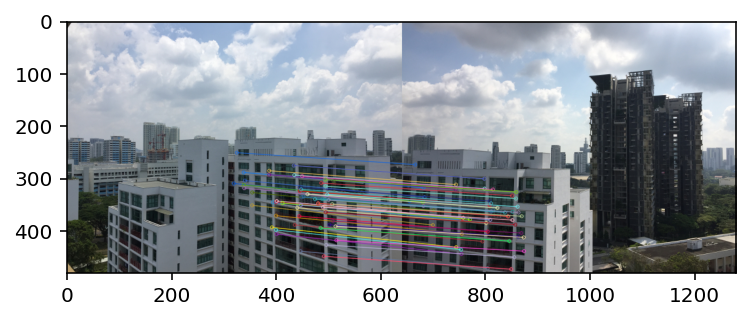

In [33]:
import random

N = len(matches)
b1 = np.zeros([N,2])
b2 = np.zeros([N,2])

# Get the coordinate of keypoint
for i in range(N):
    for j in range(2):
        b1[i,j] = kp_1[matches[i].queryIdx].pt[j]
        b2[i,j] = kp_2[matches[i].trainIdx].pt[j]

# RANSAC
iteration = 100000
k = 0
Inlier_best = 0
e = 0.5
while k < iteration:
    Intier_tmp = 0
    # Use four random pair of keypoints to compute the homography matrix
    rdm = random.sample(range(0,N),4)
    A = np.zeros([8,9])
    B1 = np.array([[b2[rdm[0]][0]],[b2[rdm[0]][1]],[b2[rdm[1]][0]],[b2[rdm[1]][1]],
                  [b2[rdm[2]][0]],[b2[rdm[2]][1]],[b2[rdm[3]][0]],[b2[rdm[3]][1]]])
    for i in range(4):
        A[2*i:2*i+2][:] = np.array([[b1[rdm[i]][0],b1[rdm[i]][1],1,0,0,0,-b2[rdm[i]][0]*b1[rdm[i]][0],-b2[rdm[i]][0]*b1[rdm[i]][1],-b2[rdm[i]][0]],
                                   [0,0,0,b1[rdm[i]][0],b1[rdm[i]][1],1,-b2[rdm[i]][1]*b1[rdm[i]][0],-b2[rdm[i]][1]*b1[rdm[i]][1],-b2[rdm[i]][1]]])
        
#     H = np.dot(linalg.inv(A),B1)
#     h33 = (1/(sum(H**2)+1))**0.5
#     h = h33*H
    u, d, vt = np.linalg.svd(A)
    hh = vt[-1].reshape(3,3)
    # compute the distance between x_ and Hx
    match = []
    for i in range(N):
        x = b1[i][0]
        y = b1[i][1]
        x1 = b2[i][0]
        y1 = b2[i][1]
        x_ = (hh[0][0]*x + hh[0][1]*y + hh[0][2])/(hh[2][0]*x + hh[2][1]*y + hh[2][2])
        y_ = (hh[1][0]*x + hh[1][1]*y + hh[1][2])/(hh[2][0]*x + hh[2][1]*y + hh[2][2])
        if ((x_ - x1)**2 + (y_ - y1)**2)**0.5 < e:
            Intier_tmp += 1
            match.append(matches[i])
    # Renew the homography matrix
    if Intier_tmp > Inlier_best:
        Inlier_best = Intier_tmp
        hh_best = hh
        match_best = match
    k += 1
    
match_bestres = cv.drawMatches(img1, kp_1, img2, kp_2, match_best, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(match_bestres)
plt.show()


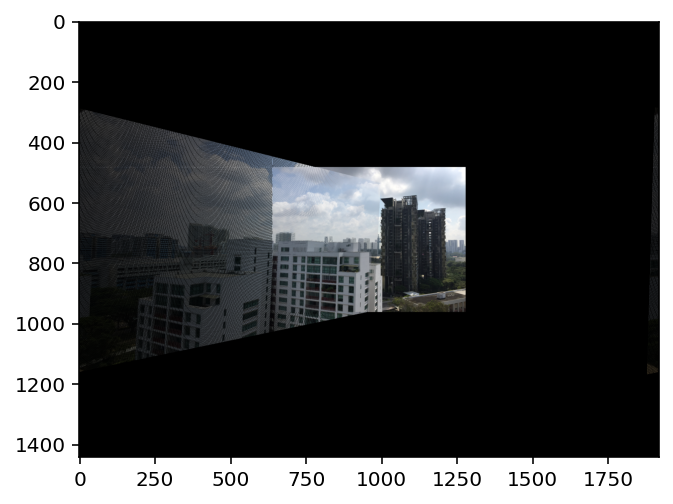

In [32]:
l1 = img1.shape[0]
w1 = img1.shape[1]
img_1 = np.zeros([3*img2.shape[0],3*img2.shape[1],img2.shape[2]])
for y in range(l1):
    for x in range(w1):
        x_1 = (hh_best[0][0]*x + hh_best[0][1]*y + hh_best[0][2])/(hh_best[2][0]*x + hh_best[2][1]*y + hh_best[2][2])
        y_1 = (hh_best[1][0]*x + hh_best[1][1]*y + hh_best[1][2])/(hh_best[2][0]*x + hh_best[2][1]*y + hh_best[2][2])
        img_1[int(y_1) + l1, int(x_1) + w1, :] = img1[y, x, :]

l2 = img1.shape[0]
w2 = img1.shape[1]
for y in range(l2):
    for x in range(w2):
        if sum(img_1[y + l1, x + w1, :]) > 0:
            img_1[y + l1, x + w1, :] = img_1[y + l1, x + w1, :]/2 + img2[y, x, :]/2
        else:
            img_1[y + l1, x + w1, :] = img2[y, x, :]

# h_down = 0
# h_up = img_1.shape[0]
# l_down = 0
# l_up = img_1.shape[1]
# while sum(sum(img_1[h_down,:,:])) == 0:
#     h_down += 1
# while sum(sum(img_1[h_up-1,:,:])) == 0:
#     h_up -= 1
# while sum(sum(img_1[:,l_down,:])) == 0:
#     l_down += 1
# while sum(sum(img_1[:,l_up-1,:])) == 0:
#     l_up -= 1
    
# plt.imshow(img_1[h_down:h_up,l_down:l_up,:]/255)
plt.imshow(img_1/255)
plt.show()